In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
from collections import OrderedDict

sns.set_theme(style="whitegrid", context="notebook")

Found missing values in price data.


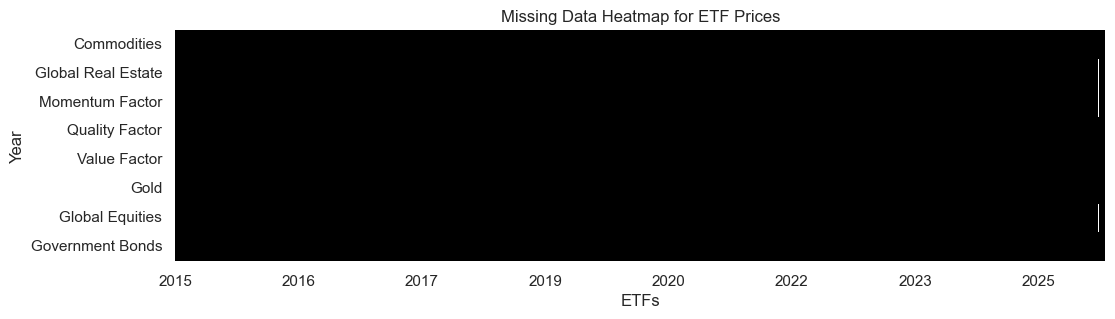

Missing values have been filled using forward-fill first, then backward-fill.


Ticker,Commodities,Global Real Estate,Momentum Factor,Quality Factor,Value Factor,Gold,Global Equities,Government Bonds
Date,,,,,,,,
2015-01-02,10.6400,17.571396,1694.75,25.575001,24.934999,1532.5,36.511490,16573.5
2015-01-05,10.5900,17.741827,1690.25,25.155001,24.327499,1554.5,36.127380,16694.5
2015-01-06,10.5875,17.938770,1684.75,24.995001,24.150000,1579.0,35.992531,16857.5
2015-01-07,10.5725,18.201994,1706.00,25.045000,24.197500,1597.5,36.343948,16872.5
2015-01-08,10.5800,18.349697,1740.00,25.615000,24.795000,1593.0,37.079494,16939.5
...,...,...,...,...,...,...,...,...
2025-11-17,12.6045,26.549999,7174.00,77.290001,57.049999,6002.0,123.330002,19279.0
2025-11-18,12.6030,26.504999,7090.00,76.269997,55.650002,6000.0,121.790001,19308.0
2025-11-19,12.5660,26.500000,7100.00,76.309998,55.540001,6057.0,122.279999,19346.0


In [2]:
ETFS = OrderedDict({
    'VWRL.L': 'Global Equities',
    'XG7S.L': 'Government Bonds',
    'IWVL.L': 'Value Factor',
    'IWQU.L': 'Quality Factor',
    'IWFM.L': 'Momentum Factor',
    'GBRE.L': 'Global Real Estate',
    'AIGC.L': 'Commodities',
    'SGLN.L': 'Gold',
})

prices = yf.download(
    list(ETFS.keys()),
    start='2015-01-01',
    end=None,
    interval='1d',
    auto_adjust=True,
    progress=False
)['Close']
prices.rename(columns=ETFS, inplace=True)

if prices.isna().sum().sum() > 0:
    print("Found missing values in price data.")
    # Visualize the missing data with a heatmap
    plt.figure(figsize=(12, 3))
    sns.heatmap(prices.isna().T, cbar=False, cmap='binary_r')
    plt.title('Missing Data Heatmap for ETF Prices')
    plt.xlabel('ETFs')
    plt.ylabel('Year')
    plt.xticks(ticks=range(0, len(prices.index), 365), labels=prices.index[::365].year, rotation=0)
    plt.show()
    prices = prices.ffill().bfill()
    print("Missing values have been filled using forward-fill first, then backward-fill.")

display(prices)

In [3]:
returns = (1 + prices.pct_change()).fillna(1)
log_returns = np.log(returns)

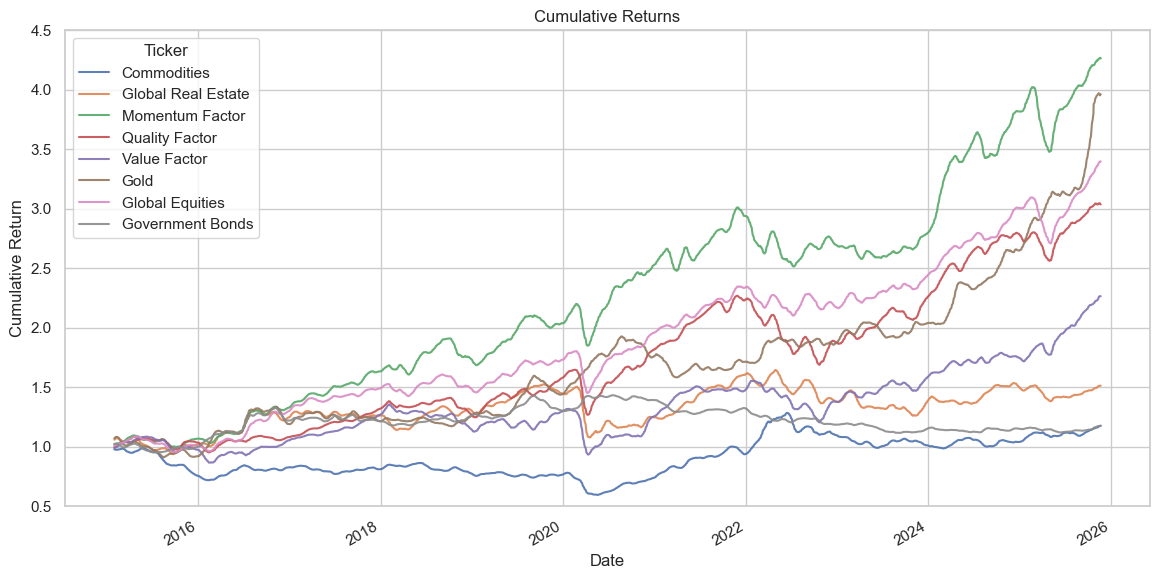

In [4]:
cumulative_returns = np.exp(log_returns.cumsum())
rolling_cumulative_returns = cumulative_returns.rolling(window=21).mean()
rolling_cumulative_returns.plot(figsize=(14, 7), title='Cumulative Returns', alpha=0.9)
plt.ylim(0.5, 4.5)
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.show()

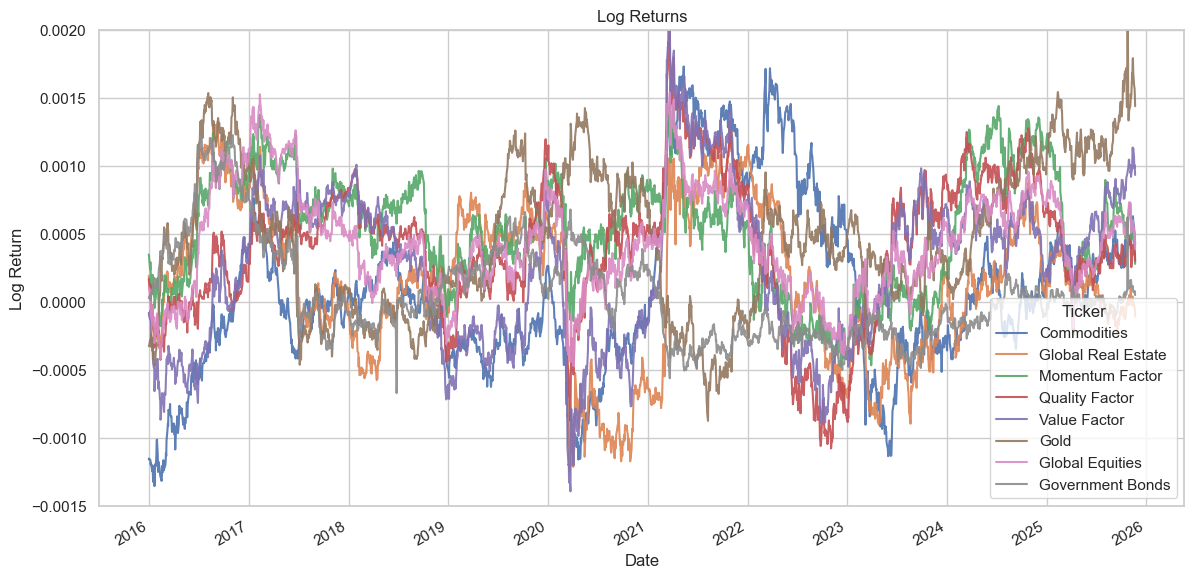

In [5]:
rolling_returns = log_returns.rolling(window=252).mean()
rolling_returns.plot(figsize=(14, 7), title='Log Returns', alpha=0.9)
plt.ylim(-0.0015, 0.002)
plt.ylabel('Log Return')
plt.xlabel('Date')
plt.show()

In [6]:
T, N = log_returns.shape

# Compute per-day mean and covariance of log returns
mu = log_returns.mean().values # shape: (N,)
Sigma = log_returns.cov().values # shape: (N, N)
asset_names = log_returns.columns.tolist() # length: N

# Annualize mean and covariance
TRADING_DAYS = 252
mu_ann = mu * TRADING_DAYS # NOTE: Annualizing log returns is easy
Sigma_ann = Sigma * TRADING_DAYS

def min_variance_portfolio(mu, Sigma, target_return, allow_short=False):
    N = len(mu)
    w0 = np.ones(N) / N

    def obj(w):
        return w @ Sigma @ w # NOTE: Portfolio variance (vol**2) = w^T @ Sigma @ w
    
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights must sum to 1
        {'type': 'eq', 'fun': lambda w: w @ mu - target_return}  # NOTE: Portfolio return = w^T @ mu
    ]

    if allow_short:
        bounds = [(None, None) for _ in range(N)] # allows weights less than 0 and greater than 1
    else:
        bounds = [(0, 1) for _ in range(N)]
    
    res = minimize(obj, w0, method='SLSQP', bounds=bounds, constraints=constraints) # Minimize vol for a given target return
    if not res.success:
        raise ValueError("Optimization failed:", res.message)
    
    w_opt = res.x
    ret = w_opt @ mu
    vol = np.sqrt(w_opt @ Sigma @ w_opt)
    return w_opt, ret, vol

# Example usage
target_return = 0.1
weights, ret, vol = min_variance_portfolio(mu_ann, Sigma_ann, target_return, allow_short=True)
print("Optimal Weights for Minimum Variance Portfolio:")
for asset, weight in zip(asset_names, weights):
    print(f"{asset}: {weight:.2%}")
print(f"Expected Annualized Return: {ret:.4f}, Volatility: {vol:.4f}")

Optimal Weights for Minimum Variance Portfolio:
Commodities: 1.66%
Global Real Estate: -16.88%
Momentum Factor: 4.75%
Quality Factor: 44.22%
Value Factor: -5.54%
Gold: 26.41%
Global Equities: 21.21%
Government Bonds: 24.17%
Expected Annualized Return: 0.1000, Volatility: 0.1001
